# Hyperspectral Clustering with PACE OCI Data

This tutorial demonstrates how to cluster hyperspectral data from NASA's PACE satellite using Dask for scalable processing. You'll learn how to:
- Load and explore hyperspectral data in an `xarray` format
- Perform dimensionality reduction using PCA
- Apply KMeans clustering on the reduced data
- Visualize and interpret clustering results on a map

---

> **Note**: This notebook is intended to run on a JupyterHub/Dask cluster environment with Dask already configured. For local development, a temporary Dask cluster can be created using `Client()`.


In [1]:
# Uncomment if running in a new environment
!pip install dask-ml

In [2]:
import logging
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import seaborn as sns

# Dask and parallel computing
import dask.array as da
from dask.distributed import Client
from dask.diagnostics import ProgressBar
from dask_ml.decomposition import PCA
from dask_ml.cluster import KMeans

# Geospatial visualization
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle

# Specialized libraries for NASA Earthdata
import earthaccess
import h5netcdf
import pyinterp.backends.xarray
import pyinterp.fill


In [3]:
# Set up basic logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
log = logging.getLogger()


In [4]:
# Connect to a running Dask cluster. Replace this with your own cluster address.
# You can start a local cluster with: Client() for debugging/testing.
client = Client("tcp://127.0.0.1:33805")
client

<Client: 'tcp://127.0.0.1:33805' processes=4 threads=4, memory=14.84 GiB>

## Downloading PACE Reflectance Data using `earthaccess`

[earthaccess](https://nasa-opensciencedata.github.io/earthaccess/) is a Python library that allows you to search, authenticate, and download NASA Earthdata directly.

This notebook uses OCI Level-3 monthly surface reflectance data from the **PACE** satellite, provided by NASA's Ocean Biology Processing Group.

You can follow these steps to search and download the data yourself:


In [5]:
# First-time only: this will open a browser to authenticate your Earthdata account
# You must have an account at https://urs.earthdata.nasa.gov
import earthaccess

earthaccess.login()

2025-08-07 16:57:14,774 - INFO - You're now authenticated with NASA Earthdata Login


In [30]:
tspan = ("2024-06-01", "2024-06-30")
figname = "results/corn_belt"
bbox =  (-97.5, 36.0, -83.0, 45.5)

# For training, choose bounds that contain sufficient representative samples of what you are trying to classify
min_lon_train, max_lat_train, max_lon_train, min_lat_train = bbox

In [8]:
# Search for surface reflectance (rhos) products in June 2024
res_rf = earthaccess.search_data(
    short_name="PACE_OCI_L3M_SFREFL",
    temporal=tspan,
    granule_name='*.MO.*0p1deg*',
    bounding_box=bbox
)

# Preview what was found
log.info(f"Found {len(res_rf)} datasets")

2025-08-07 16:58:17,387 - INFO - Granules found: 1
2025-08-07 16:58:39,306 - INFO - Found 1 datasets


Now that we have a NetCDF file, we can load it directly into an `xarray.Dataset` for analysis.

In [10]:
# Open results in xarray dataset
paths = earthaccess.open(res_rf)
ds_rf = xr.open_mfdataset(paths, combine="nested", concat_dim="date")

# Cut out AOI
min_lon, max_lat, max_lon, min_lat = bbox
ds_rf = ds_rf.sel(lat=slice(min_lat, max_lat), lon=slice(min_lon, max_lon))

2025-08-07 16:58:55,435 - INFO - Opening 1 granules, approx size: 1.44 GB
2025-08-07 16:58:55,437 - INFO - using endpoint: https://obdaac-tea.earthdatacloud.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
# Load and inspect the dataset
ds_rf

<xarray.Dataset> Size: 7MB
Dimensions:     (date: 1, lat: 95, lon: 145, wavelength: 122, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 976B 346.0 351.0 ... 2.131e+03 2.258e+03
  * lat         (lat) float32 380B 45.45 45.35 45.25 45.15 ... 36.25 36.15 36.05
  * lon         (lon) float32 580B -97.45 -97.35 -97.25 ... -83.25 -83.15 -83.05
Dimensions without coordinates: date, rgb, eightbitcolor
Data variables:
    rhos        (date, lat, lon, wavelength) float32 7MB dask.array<chunksize=(1, 3, 145, 8), meta=np.ndarray>
    palette     (date, rgb, eightbitcolor) uint8 768B dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/62)
    product_name:                      PACE_OCI.20240601_20240630.L3m.MO.SFRE...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L3M/SFREFL/3.0
    data_bins:                         4819468
    data_minimum:                      -0.050000016
    data_maximum:                      1.0

In [12]:
# Choose approximate RGB wavelengths (in nm)
wavelengths_rgb = [660, 550, 470]  # Red, Green, Blue
wavelength_idx = [int(abs(ds_rf.wavelength - wl).argmin()) for wl in wavelengths_rgb]

# Extract RGB bands from reflectance data
rhos = ds_rf['rhos'].isel(date=0, wavelength=wavelength_idx)  # shape: (lat, lon, 3)

# Rearrange to (3, lat, lon)
rgb = rhos.transpose('wavelength', 'lat', 'lon')

# Normalize reflectance to 8-bit integer scale for saving
rgb = rgb.clip(min=0)
rgb_uint8 = (rgb / rgb.max() * 255).astype("uint8")

# Assign spatial reference
rgb_uint8.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
rgb_uint8.rio.write_crs("EPSG:4326", inplace=True)

# Save to file
rgb_uint8.rio.to_raster("pace_rgb_truecolor.tif")

## Prepare Bands and Subset for Training

We'll remove extra visualization bands (`palette`), and select specific wavelengths (550nm, 704nm, 804nm) to use as features.
We’ll also clip a small geographic region to use as a training tile for dimensionality reduction and clustering.


In [26]:
# Drop palette bands
dims_to_remove = {'rgb', 'eightbitcolor'}
vars_to_drop = [var for var in ds_rf.data_vars if dims_to_remove & set(ds_rf[var].dims)]
ds_rf = ds_rf.drop_vars(vars_to_drop)

# Select bands for PCA/clustering
rhos = [550, 704, 804]
ds_rf = ds_rf.sel(wavelength=rhos)


ds_train = ds_rf.sel(lat=slice(min_lat_train, max_lat_train), lon=slice(min_lon_train, max_lon_train))

## Tiling Function for Model Prediction

We'll define a helper function `predict_on_tiles()` that:
- Splits the data into spatial tiles (e.g., 200x200)
- Applies PCA + clustering model to each tile
- Stitches the results together into a global map

This allows us to scale prediction to the full dataset without running into memory issues.


In [14]:
def prep_tile(tile):
    """Reshape a small tile: stack lat/lon and flatten features."""
    log.info(f"Preparing tile with shape {tile.sizes}")
    stacked = tile.stack(samples=("lat", "lon")).transpose("samples", "date", "wavelength")
    X = stacked.data
    log.info(f"  -> stacked shape: {X.shape}, chunks: {X.chunks}")
    X = da.where(da.isnan(X), 0, X)
    X = X.rechunk({0: -1, 1: -1, 2: -1})  # ensure fully rechunked before reshape
    X_flat = X.reshape((X.shape[0], -1))
    log.info(f"  -> reshaped to: {X_flat.shape}, chunks: {X_flat.chunks}")
    return X_flat, stacked

In [15]:
def predict_on_tiles(ds, model, tile_size=200):
    lat_chunks = range(0, ds.dims["lat"], tile_size)
    lon_chunks = range(0, ds.dims["lon"], tile_size)

    predicted_tiles = []

    for lat_start in lat_chunks:
        lat_end = min(lat_start + tile_size, ds.dims["lat"])
        row_tiles = []
        log.info(f"  Processing lat slice {lat_start}:{lat_end}")

        for lon_start in lon_chunks:
            lon_end = min(lon_start + tile_size, ds.dims["lon"])
            log.info(f"  → lon slice {lon_start}:{lon_end}")
            tile = ds["rhos"].isel(lat=slice(lat_start, lat_end), lon=slice(lon_start, lon_end))

            if tile.count().values == 0:
                log.info("Skipping empty tile")
                continue

            try:
                X_flat, stacked = prep_tile(tile)
                X_np = X_flat.compute()
                labels = model.predict(X_np)
                labels_xr = xr.DataArray(labels, coords={"samples": stacked["samples"]}, dims="samples")
                labels_unstacked = labels_xr.unstack("samples")
                row_tiles.append(labels_unstacked)
                log.info(f"  Finished prediction on tile")
            except Exception as e:
                log.warning(f"  Failed to process tile: {e}")
                continue

        if row_tiles:
            log.info(f"Concatenating row tiles along 'lon'")
            predicted_row = xr.concat(row_tiles, dim="lon")
            predicted_tiles.append(predicted_row)

    if predicted_tiles:
        log.info("Concatenating all rows into full label map")
        full_labels = xr.concat(predicted_tiles, dim="lat")
        return full_labels

    log.warning("No tiles were processed successfully.")
    return None

## KMeans Clustering on Hyperspectral Reflectance

We apply **KMeans clustering** directly to reflectance values across multiple wavelengths.

Each pixel is treated as a high-dimensional vector representing its spectral signature.
By clustering these vectors, we can:
- Identify spectrally similar regions across the image
- Group land cover types or physical features with similar reflectance

This unsupervised approach avoids manual labeling and helps explore spectral variability.


In [28]:
# Reshape training data: (lat, lon, wavelength) → (pixels, wavelength)
ds_train = ds_train.stack(samples=("lat", "lon")).transpose("samples", "date", "wavelength")
X_train = ds_train["rhos"].data
X_train = X_train.squeeze()  # drop 'date' dimension
X_train = da.where(da.isnan(X_train), 0, X_train)

# Fully rechunk for clustering
X_train = X_train.rechunk({0: -1, 1: -1})

In [34]:
ds_train['samples']

<xarray.DataArray 'samples' (samples: 13775)> Size: 110kB
[13775 values with dtype=object]
Coordinates:
  * samples  (samples) object 110kB MultiIndex
  * lat      (samples) float32 55kB 45.45 45.45 45.45 ... 36.05 36.05 36.05
  * lon      (samples) float32 55kB -97.45 -97.35 -97.25 ... -83.15 -83.05

2025-08-07 17:07:04,882 - INFO - Starting _check_array
2025-08-07 17:07:09,142 - INFO - Finished _check_array in 0:00:04.260096
2025-08-07 17:07:09,143 - INFO - Starting init_scalable
2025-08-07 17:07:09,144 - INFO - Initializing with k-means||
2025-08-07 17:07:18,245 - INFO - Starting init iteration  1/ 6 ,  1 centers
2025-08-07 17:07:23,342 - INFO - Finished init iteration  1/ 6 ,  1 centers in 0:00:05.097168
2025-08-07 17:07:27,813 - INFO - Starting init iteration  2/ 6 ,  3 centers
2025-08-07 17:07:32,445 - INFO - Finished init iteration  2/ 6 ,  3 centers in 0:00:04.632201
2025-08-07 17:07:36,987 - INFO - Starting init iteration  3/ 6 ,  6 centers
2025-08-07 17:07:42,259 - INFO - Finished init iteration  3/ 6 ,  6 centers in 0:00:05.272345
2025-08-07 17:07:46,251 - INFO - Starting init iteration  4/ 6 , 11 centers
2025-08-07 17:07:51,216 - INFO - Finished init iteration  4/ 6 , 11 centers in 0:00:04.964479
2025-08-07 17:07:55,728 - INFO - Starting init iteration  5/ 6 , 14 centers

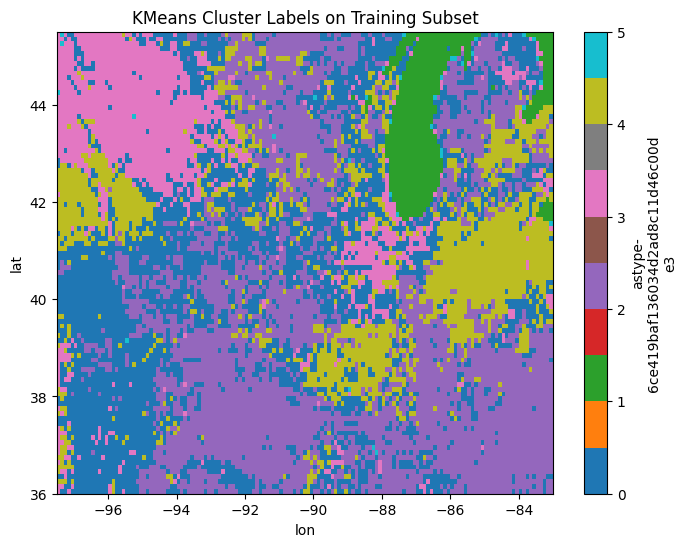

In [35]:
from dask_ml.cluster import KMeans

# Apply KMeans clustering directly on reflectance vectors
kmeans = KMeans(n_clusters=10)
kmeans.fit(X_train)
labels = kmeans.predict(X_train)

# Restore spatial shape for visualization
labels_xr = xr.DataArray(labels, coords={"samples": ds_train["samples"]}, dims="samples")
labels_2d = labels_xr.unstack("samples")

# Plot
plt.figure(figsize=(8, 6))
labels_2d.plot(cmap="tab10")
plt.title("KMeans Cluster Labels on Training Subset")
plt.savefig("pace_training_clusters.png")
plt.show()


## Predicting Across the Full Image

To scale up to the full image, we tile it into smaller chunks (e.g. 200x200).
Each tile is reshaped and passed into the same clustering model to assign labels.

The labeled tiles are then stitched together into a global cluster map.


2025-08-07 17:09:07,447 - INFO - Starting tile-wise prediction...
2025-08-07 17:09:07,448 - INFO -   Processing lat slice 0:95
2025-08-07 17:09:07,449 - INFO -   → lon slice 0:145
2025-08-07 17:09:11,502 - INFO - Preparing tile with shape Frozen({'date': 1, 'lat': 95, 'lon': 145, 'wavelength': 3})
2025-08-07 17:09:11,510 - INFO -   -> stacked shape: (13775, 1, 3), chunks: ((435, 2320, 2320, 2320, 2320, 2320, 1740), (1,), (3,))
2025-08-07 17:09:11,513 - INFO -   -> reshaped to: (13775, 3), chunks: ((13775,), (3,))
2025-08-07 17:09:16,572 - INFO - Starting _check_array
2025-08-07 17:09:16,650 - INFO - Finished _check_array in 0:00:00.077467
2025-08-07 17:09:16,662 - INFO -   Finished prediction on tile
2025-08-07 17:09:16,663 - INFO - Concatenating row tiles along 'lon'
2025-08-07 17:09:16,665 - INFO - Concatenating all rows into full label map
2025-08-07 17:09:16,668 - INFO - Prediction complete. Plotting result...


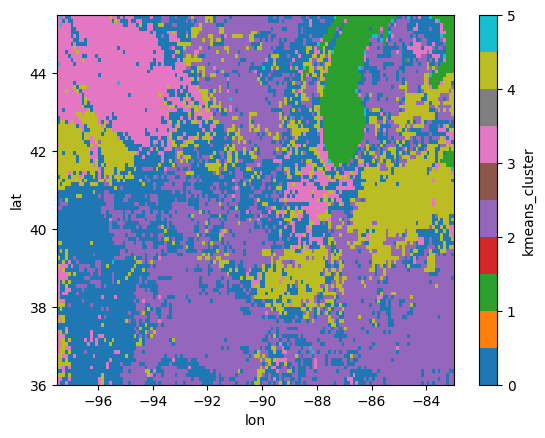

In [37]:
log.info("Starting tile-wise prediction...")
labels_2d = predict_on_tiles(ds_rf, kmeans, tile_size=200)

if labels_2d is not None:
    labels_2d.name = "kmeans_cluster"
    log.info("Prediction complete. Plotting result...")
    labels_2d.plot.imshow(cmap='tab10')
else:
    log.error("Clustering failed: no valid output generated.")


In [38]:
log.info("Writing output to GeoTIFF...")
labels_2d = labels_2d.sortby("lat", ascending=False)
labels_2d.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
labels_2d.rio.write_crs("EPSG:4326", inplace=True)
labels_2d.rio.to_raster(f"{figname}_kmeans_clusters.tif")
log.info("GeoTIFF saved as kmeans_clusters.tif")

2025-08-07 17:09:18,188 - INFO - Writing output to GeoTIFF...
2025-08-07 17:09:18,277 - INFO - GeoTIFF saved as kmeans_clusters.tif


In [39]:
ds_with_labels = ds_rf.copy()
ds_with_labels['cluster'] = labels_2d
ds_with_labels

<xarray.Dataset> Size: 221kB
Dimensions:      (date: 1, lat: 95, lon: 145, wavelength: 3)
Coordinates:
  * wavelength   (wavelength) float64 24B 550.0 704.0 804.0
  * lat          (lat) float32 380B 45.45 45.35 45.25 ... 36.25 36.15 36.05
  * lon          (lon) float32 580B -97.45 -97.35 -97.25 ... -83.15 -83.05
    spatial_ref  int64 8B 0
Dimensions without coordinates: date
Data variables:
    rhos         (date, lat, lon, wavelength) float32 165kB dask.array<chunksize=(1, 3, 145, 3), meta=np.ndarray>
    cluster      (lat, lon) int32 55kB dask.array<chunksize=(23, 145), meta=np.ndarray>
Attributes: (12/62)
    product_name:                      PACE_OCI.20240601_20240630.L3m.MO.SFRE...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L3M/SFREFL/3.0
    data_bins:                         4819468
    data_minimum:                      -0.050000016
    data_maximum:                      1.0

In [40]:
rhos = ds_with_labels['rhos'].values  # shape: (lat, lon, wavelength)
clusters = ds_with_labels['cluster'].values  # shape: (lat, lon)
wavelengths = ds_with_labels['wavelength'].values

rhos_single = np.squeeze(rhos, axis=0)  # squeeze out the "date" or "time" dimension

rhos_flat = rhos_single.reshape(-1, rhos_single.shape[-1])  

clusters_flat = clusters.ravel()


cluster_ids = np.unique(clusters_flat[~np.isnan(clusters_flat)]).astype(int)

spectra_per_cluster = []

for cid in cluster_ids:
    mask = clusters_flat == cid                    # shape: (lat*lon,)
    cluster_rhos = rhos_flat[mask, :]              # shape: (N, wavelength)
    mean_spectrum = cluster_rhos.mean(axis=0)
    spectra_per_cluster.append((cid, mean_spectrum))


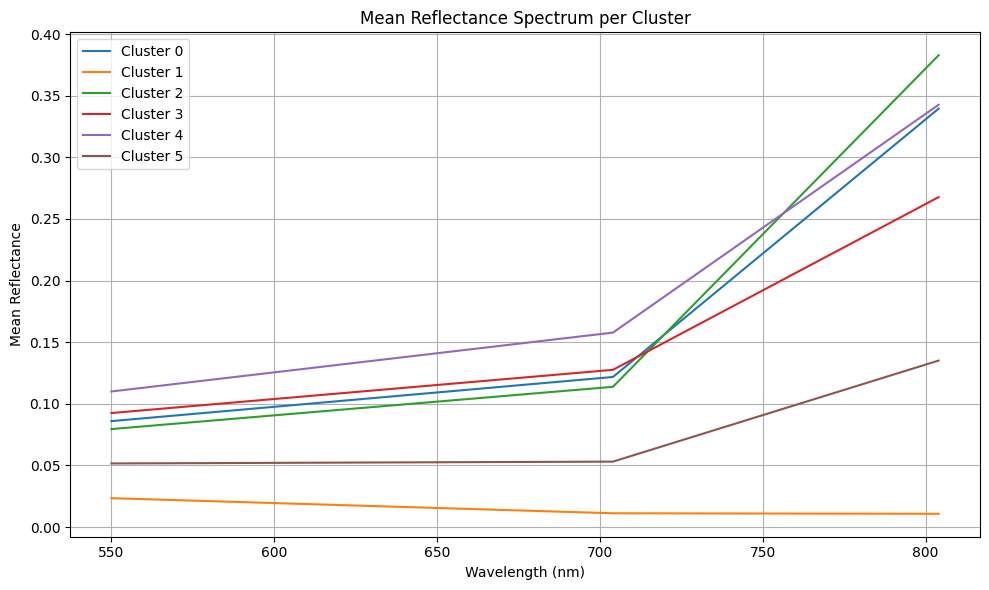

In [41]:
plt.figure(figsize=(10, 6))
for cid, spectrum in spectra_per_cluster:
    plt.plot(wavelengths, spectrum, label=f'Cluster {cid}')

plt.xlabel('Wavelength (nm)')
plt.ylabel('Mean Reflectance')
plt.title('Mean Reflectance Spectrum per Cluster')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{figname}_mrs.png')
plt.show()